# **Sunday Afternoon Fever**
#### Analyzing **DIS**guised **CO**verages on Defense

# Introduction

Football is a sport where game theory and deception are components to almost every single play.  In addition to great talent, football fans love to watch how head coaches, coordinators, and players are constantly trying to outsmart their opponents.   One of many opportunities for teams to leverage deception is with defensive pre-snap alignments, when a defense’s goal is to confuse the offense as to what pass coverage they will run.  Perhaps they are disguising a coverage, or they want the offense to *believe* a disguised coverage is coming when it is not.  Thanks to the NFL and Next Gen Stats, we developed and propose a metric that evaluates the frequency each team’s defense disguises their coverage in the moments before the ball is snapped: *DISCO*

#### ***DISCO***: ***DIS***guised ***CO***verage %:
- The percent of snaps a team’s defense transforms into a pass coverage that is observed less than 10% of cases (among all NFL snaps in a season) following their presented pre-snap alignment.
- Note: This metric can also be broken down by pre-snap alignment type, as we will explore below.

# Approach for Developing DISCO

Our approach involves leveraging an unsupervised machine learning model, [K-Medoids](https://medium.com/@prasanNH/exploring-the-world-of-clustering-k-means-vs-k-medoids-f648ea738508), to separate thousands of pre-snap alignments into clusters, and then to analyze the resulting clusters to learn about what they entail post-snap.  Because typically the behaviors of defensive backs pre-snap provide the best indications into what coverage the defense may run, we found that linemen and linebacker data added noise to our model that did not enhance our output and analysis.

##### We focus our model on the following metrics:

-	SS horizontal distance from ball 
-	SS vertical distance from ball 
-	FS horizontal distance from ball
-	FS vertical distance from ball
-	For each CB
    - Horizontal distance from ball
    - Vertical distance from ball
    - Horizontal distance from nearest receiver
    - Vertical distance from nearest receiver
    - Body orientation 
-	For offensive plays using a pre-snap motion
- Defender motion relative to receiver motion
- Direction of DB motion (if applicable)

##### Potentially Relevant Metrics Not Included
- Verbal Signals
- Hand Gestures/Pointing
- Direction player is leaning
- Direction a player is looking (independent  of body orientation)
- Game situation (e.g. - down, yards, score, previous play(s)
- Team Historical Alignments


We capture the location and orientation metrics at 2 seconds before the snap, and motion metrics throughout the pre-snap period.  We found that defenses are more likely to reveal their alignment as time passes from the huddle break, yet we need to use a time early enough that the metric can be relevant to a QB/offense who has a moment to process what is seen.


The function of the K-Medoids model is to identify data points among a cluster of similar data (data within proximity) while differentiating data points that are far apart.  For example, just as a QB can often spot the difference between a Cover 1 and Cover 3 based on the distance outside-backs are from receivers and perhaps their body orientation, even if a similar location of a middle deep safety, the cluster algorithm can recognize those alignments as distinct.  The purpose of identifying unique clusters in an unsupervised model is not to predict the defenses coverage, but to further explore post-snap coverages as a function of pre-snap alignments.  

# Import Packages

In [689]:
#import packages
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sn
#from  plotnine import *

#import ggplot
#from ggplot import *
import io
import re as re
pd.set_option('display.float_format', lambda x: '%.2f' % x)
#import xlsxwriter
#from pandas import ExcelWriterter
import matplotlib.pyplot as plt
pd.options.display.max_columns = 100
import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# Read in Data

In [691]:
#read in data and parse dates, adjust other data types 
import os
os.chdir('/Users/drewmalter/Documents/Personal/NFL/nfl_big_data_bowl_25/data')
#df_plays = pd.read_csv('plays.csv', parse_dates = ['GameDate'])
df_plays = pd.read_csv('plays.csv')
df_games = pd.read_csv('games.csv')
df_players = pd.read_csv('players.csv')
df_player_play = pd.read_csv('player_play.csv')
df_week1 = pd.read_csv('tracking_week_1.csv', parse_dates = ['time'])
df_week2 = pd.read_csv('tracking_week_2.csv', parse_dates = ['time'])
df_week3 = pd.read_csv('tracking_week_3.csv', parse_dates = ['time'])
df_week4 = pd.read_csv('tracking_week_4.csv', parse_dates = ['time'])
df_week5 = pd.read_csv('tracking_week_5.csv', parse_dates = ['time'])
df_week6 = pd.read_csv('tracking_week_6.csv', parse_dates = ['time'])
df_week7 = pd.read_csv('tracking_week_7.csv', parse_dates = ['time'])
df_week8 = pd.read_csv('tracking_week_8.csv', parse_dates = ['time'])
df_week9 = pd.read_csv('tracking_week_9.csv', parse_dates = ['time'])
#df_week1.head()

# Prep Play Game Data

In [693]:
#Data Prep

#Concat all weekly df's into one
df_weeks = pd.concat([df_week1, df_week2, df_week3, df_week4, df_week5, df_week6, df_week7, df_week8, df_week9])
#df_weeks.shape

In [694]:
#filter for only plays with an offensive formation
df_plays_filtered = df_plays.loc[df_plays['offenseFormation'].notnull()]

#filter out plays where the score is 3 possesions difference or more in the second half (teams are more predictable in this case)
##For improvement - model out scenarios where we should filter out - not just make this assumption
df_plays_filtered = df_plays_filtered.loc[(abs(df_plays_filtered['preSnapHomeScore'] - df_plays_filtered['preSnapVisitorScore']) < 17) 
| (df_plays_filtered['quarter'] <3)]

#filter out plays in the final 2 minutes of a half/game - same situation as above
df_plays_filtered['game_clock_numeric'] = df_plays_filtered.gameClock.str[:2].astype(float) +  df_plays_filtered.gameClock.str[-2:].astype(float)/60
df_plays_filtered = df_plays_filtered.loc[(df_plays_filtered.game_clock_numeric >= 2) | (df_plays_filtered.quarter == 1) | (df_plays_filtered.quarter == 3)]

#df_plays_filtered.shape
#df_plays_filtered.head()

In [695]:
#Join games to plays to get if offense or defense is home or visitor
df_plays_games = pd.merge(df_plays_filtered, df_games, on = 'gameId', how = 'left')
df_plays_games['possessionTeam_ishome'] = np.where(df_plays_games.homeTeamAbbr ==  df_plays_games.possessionTeam, 1, 0)
df_plays_games['offensive_outcome_prob_change'] = np.where((df_plays_games.possessionTeam_ishome ==  1), df_plays_games.homeTeamWinProbabilityAdded, df_plays_games.visitorTeamWinProbilityAdded)

#convert NaN to blank because we will be using the text to concat to other fields to make a 'scheme'
df_plays_games['is_playAction'] = np.where(df_plays_games.playAction == True, 'PLAY ACTION', '')
df_plays_games['is_Dropback'] = np.where(df_plays_games.isDropback == True, 'DROPBACK', '')

df_plays_games['pff_runConceptPrimary'] = np.where((df_plays_games.pff_runConceptPrimary == 'UNDEFINED') | (df_plays_games.pff_runConceptPrimary.isnull()), '', df_plays_games.pff_runConceptPrimary)
df_plays_games['pff_runConceptSecondary'] = np.where(df_plays_games.pff_runConceptSecondary.isnull(), '', df_plays_games.pff_runConceptSecondary)

#create offensive and defensive scheme variables
df_plays_games['offensive_scheme'] = df_plays_games.is_playAction.astype(str) + ' ' + df_plays_games.dropbackType.astype(str) #+ ' ' + df_plays_games.is_Dropback.astype(str)
df_plays_games['offensive_scheme'] = np.where(df_plays_games.rushLocationType.isnull(), df_plays_games['offensive_scheme'], 'RUN ' + df_plays_games.rushLocationType) #+ ' ' + df_plays_games.pff_runConceptPrimary + ' ' #+ df_plays_games.pff_runConceptSecondary

df_plays_games['defensive_scheme'] = df_plays_games.pff_passCoverage.astype(str) + ' ' + df_plays_games.pff_manZone.astype(str)

#df_plays_games.tail(2)
#df_plays_games.defensive_scheme.unique()

In [696]:
#Get number of route runners and initial pass rushers on each play to add to the schemes
df_player_play['is_route_runner'] = np.where(df_player_play.wasRunningRoute == 1, 1, 0)
df_player_play['is_initial_pass_rusher'] = np.where(df_player_play.wasInitialPassRusher == 1, 1, 0)
df_routes = df_player_play.loc[df_player_play['hadRushAttempt'] == 0].groupby(
   ['gameId', 'playId'] 
).agg(
    {
        'is_route_runner': 'sum'
        , 'is_initial_pass_rusher': 'sum'
        
    }
).reset_index().sort_values(by = 'playId', ascending = False)
df_routes = df_routes.rename(columns={'is_route_runner': 'route_runners'})
df_routes = df_routes.rename(columns={'is_route_runner': 'initial_pass_rushers'})
df_routes['pass_rushers'] = np.where(df_routes['is_initial_pass_rusher']>=5, '5+', '4')
#df_routes.sort_values(by = 'is_initial_pass_rusher', ascending = False)
#df_routes.tail()

In [697]:
#Create a column for each route ran in the play

#the players should be in order from QBs left to QBs right for consitancy in the column
df_weeks_snap_time = df_weeks.loc[df_weeks['event'] == 'ball_snap'].reset_index()

#If direction of offense play direction is left, then reverse the sign of the y
df_weeks_snap_time.loc[df_weeks_snap_time['playDirection'] == 'left', 'y'] = -1 * df_weeks_snap_time.y
df_weeks_snap_time = df_weeks_snap_time[['gameId', 'playId', 'nflId', 'y']]


df_player_play_routes = df_player_play.loc[df_player_play['is_route_runner'] == 1]
df_player_play_routes = pd.merge(df_player_play_routes, df_weeks_snap_time, on = ['gameId', 'playId', 'nflId'], how = 'left')

df_player_play_routes = df_player_play_routes.sort_values(by = ['gameId', 'playId', 'y'], ascending = [True, True, False])

# Step 1: Create a sequential row index for each `id`
df_player_play_routes['player'] = df_player_play_routes.groupby(['gameId', 'playId']).cumcount() + 1

# Step 2: Pivot table to create 22 new columns (2 columns per row number)
pivoted = df_player_play_routes.pivot(index=['gameId', 'playId'], columns='player', values=['routeRan'])

# Step 3: Flatten MultiIndex columns
pivoted.columns = [f"player{col[1]}_{col[0]}" for col in pivoted.columns]

# Step 4: Merge with other columns (retain non-pivoted columns)
non_pivoted = df_player_play_routes.drop_duplicates(subset=['gameId', 'playId']).set_index(['gameId', 'playId'])
non_pivoted = non_pivoted.drop(columns=['routeRan', 'player'])
df_player_play_routes = non_pivoted.join(pivoted).reset_index()


#join back to df routes
df_player_play_routes = df_player_play_routes[['gameId', 'playId', 'player1_routeRan', 'player2_routeRan', 'player3_routeRan'
                      , 'player4_routeRan', 'player5_routeRan']]
df_routes = pd.merge(df_routes, df_player_play_routes, on = ['gameId', 'playId'], how = 'left').fillna('')
#df_routes.head()

In [698]:
df_plays_games = pd.merge(df_plays_games, df_routes, on = ['gameId', 'playId'], how = 'left')
#df_plays_games.head()

In [699]:
df_plays_games['defensive_scheme'] = np.where(df_plays_games.rushLocationType.notnull(), df_plays_games['defensive_scheme'], df_plays_games['defensive_scheme'] + ' ' + df_plays_games['is_initial_pass_rusher'].astype(str) + ' RUSH')
df_plays_games['offensive_scheme'] = np.where(df_plays_games.rushLocationType.notnull(), df_plays_games['offensive_scheme'], df_plays_games['offensive_scheme'] + ' ' + df_plays_games['route_runners'].astype(str) + ' OUT')
#df_plays_games.head()    

In [700]:
# df_pass_coverages = df_plays_games.groupby(
#    ['pff_passCoverage', 'pff_manZone'
#    ] 
# ).agg(
#     {
#         'playId': 'count'
#     }
# ).reset_index()
# df_pass_coverages.sort_values(by = 'playId', ascending = False)

In [701]:
#group offensive shcemes into more broad categories for simplicity 
df_plays_games['offensive_scheme_cat'] = df_plays_games['offensive_scheme']
df_plays_games['offensive_scheme_cat'] = df_plays_games['offensive_scheme_cat'].replace(' DESIGNED_', ' ', regex=True)
df_plays_games['offensive_scheme_cat'] = df_plays_games['offensive_scheme_cat'].replace(' SCRAMBLE_', ' ', regex=True)
df_plays_games['offensive_scheme_cat'] = df_plays_games['offensive_scheme_cat'].replace('UNKNOWN', '', regex=True)
df_plays_games['offensive_scheme_cat'] = df_plays_games['offensive_scheme_cat'].replace('nan', '', regex=True)
df_plays_games['offensive_scheme_cat'] = df_plays_games['offensive_scheme_cat'].replace('_', ' ', regex=True)
#df_plays_games['offensive_scheme_cat'] = df_plays_games['offensive_scheme_cat'].replace('  ', ' ', regex=True)
#df_plays_games['offensive_scheme_cat'] = df_plays_games['offensive_scheme_cat'].replace(' SCRAMBLE', 'SCRAMBLE', regex=True)
#df_plays_games['offensive_scheme_cat'] = df_plays_games['offensive_scheme_cat'].replace(' TRADITIONAL', 'TRADITIONAL', regex=True)
df_plays_games['offensive_scheme_cat'] = df_plays_games['offensive_scheme_cat'].str.lstrip()
#df_plays_games.offensive_scheme_cat.unique()

In [702]:
#group pass coverages into more broad categories for simplicity 
df_plays_games['pff_passCoverageCat'] = 'Other'
df_plays_games.loc[df_plays_games.pff_passCoverage.fillna('').str.contains('3'), 'pff_passCoverageCat'] = 'Cover 3'
df_plays_games.loc[df_plays_games.pff_passCoverage.fillna('').str.contains('2'), 'pff_passCoverageCat'] = 'Cover 2'
df_plays_games.loc[df_plays_games.pff_passCoverage.fillna('').str.contains('1'), 'pff_passCoverageCat'] = 'Cover 1'
df_plays_games.loc[df_plays_games.pff_passCoverage.fillna('').str.contains('6'), 'pff_passCoverageCat'] = 'Cover 6'
df_plays_games.loc[df_plays_games.pff_passCoverage.fillna('').str.contains('0'), 'pff_passCoverageCat'] = 'Cover 0'
df_plays_games.loc[df_plays_games.pff_passCoverage.fillna('').str.contains('Quarters'), 'pff_passCoverageCat'] = 'Quarters'

# Prep Player Tracking Data

In [704]:
#Get the timestamp of the snap
df_weeks['time'] = pd.to_datetime(df_weeks['time'], errors='coerce')

df_snaps = df_weeks.loc[df_weeks['frameType'] == 'SNAP'].groupby(
   ['gameId', 'playId'
   ] 
).agg(
    {
        'time': 'first'
    }
).reset_index()

df_snaps = df_snaps.rename(columns={'time': 'time_of_snap'})


#df_snaps.head()

In [705]:
##filter df weeks to only records that are 5 seconds before the snap
df_weeks_snaps = pd.merge(df_weeks, df_snaps, on = ['gameId', 'playId'], how = 'left')

df_weeks_snaptime = df_weeks_snaps.loc[(df_weeks_snaps['time_of_snap'] == df_weeks_snaps['time'])]
df_weeks_5secs = df_weeks_snaps.loc[(df_weeks_snaps['time_of_snap'] - df_weeks_snaps['time']).dt.total_seconds() == 2]
#df_weeks_5secs.head()

In [706]:
#Get the coordinates of the football on each play at snap time
#df_players_centers = df_players[['nflId', 'position']].loc[df_players['position'] == 'C']


#innter join centers to weeks to only get records of the center
#df_weeks_centers = pd.merge(df_weeks_snaptime, df_players_centers, on = 'nflId', how = 'inner')

df_weeks_centers = df_weeks_snaptime[['gameId', 'playId', 'x', 'y', 'displayName']].loc[df_weeks_snaptime['displayName'] == 'football']
df_weeks_centers = df_weeks_centers[['gameId', 'playId', 'x', 'y']]
df_weeks_centers = df_weeks_centers.rename(columns={'x': 'x_center', 'y': 'y_center'})

#if 2 centers on play pick first one
df_weeks_centers = df_weeks_centers.drop_duplicates(subset = ['gameId', 'playId'])
df_weeks_centers.head()


# #make sure only 1 center per play

# df_centers_test = df_weeks_centers.groupby(
#    ['gameId', 'playId'
#    ] 
# ).agg(
#     {
#         'x_center': 'count'
#     }
# ).reset_index()
# df_centers_test.sort_values(by = 'x_center', ascending = False).head(50)


#get coords of receivers at each play at snap time
df_players_wr = df_players[['nflId', 'position']].loc[df_players['position'] == 'WR']


#innter join centers to weeks to only get records of the center
df_weeks_wr = pd.merge(df_weeks_snaptime, df_players_wr, on = 'nflId', how = 'inner')

df_weeks_wr = df_weeks_wr[['gameId', 'playId', 'nflId', 'x', 'y']]
df_weeks_wr = df_weeks_wr.rename(columns={'x': 'x_wr', 'y': 'y_wr'})



#get coords of dbacks at each play at snap time
df_players_db = df_players[['nflId', 'position']].loc[(df_players['position'] == 'CB') | (df_players['position'] == 'SS') |(df_players['position'] == 'FS')]


#innter join centers to weeks to only get records of the center
df_players_db = pd.merge(df_weeks_snaptime, df_players_db, on = 'nflId', how = 'inner')

df_players_db = df_players_db[['gameId', 'playId', 'nflId', 'x', 'y']]
df_players_db = df_players_db.rename(columns={'x': 'x_db', 'y': 'y_db'})


#get direction of cb 
df_players_cb = df_players[['nflId', 'position']].loc[(df_players['position'] == 'CB')]


#innter join centers to weeks to only get records of the center
df_players_cb = pd.merge(df_weeks_snaptime, df_players_cb, on = 'nflId', how = 'inner')

df_players_cb = df_players_cb[['gameId', 'playId', 'nflId', 'o', 'playDirection']]
df_players_cb = df_players_cb.rename(columns={'d': 'o_cb'})
df_players_cb.loc[(df_players_cb.playDirection == 'right'), 'o'] = 360 - df_players_cb['o']
#just care how far from 90 degrees they are
df_players_cb['o'] = abs(90 - df_players_cb.o)
df_players_cb = df_players_cb[['gameId', 'playId', 'nflId', 'o']]

#join cb orientation to db df
df_players_db = pd.merge(df_players_db, df_players_cb, on = ['gameId', 'playId', 'nflId'], how = 'left')


#if 2 centers on play pick first one
df_weeks_centers = df_weeks_centers.drop_duplicates(subset = ['gameId', 'playId'])
#df_weeks_centers.head()
#df_players_db.head(50)

In [707]:
#get the x and y deltas of each player on defense from the center 5 seconds before the snap

#also bring in the offensive alginment and formation because the defensive alignment will depend on it


#filter df weeks for defense
df_defensive_team = df_plays_games[['gameId', 'playId', 'defensiveTeam']]
df_defensive_team = df_defensive_team.rename(columns={'defensiveTeam': 'club'})
df_defensive_weeks5secs = pd.merge(df_weeks_5secs, df_defensive_team, on = ['gameId', 'playId', 'club'], how = 'inner')

df_defensive_weeks5secs = pd.merge(df_defensive_weeks5secs, df_weeks_centers, on = ['gameId', 'playId'])

df_defensive_weeks5secs['x_delta'] = df_defensive_weeks5secs['x'] - df_defensive_weeks5secs['x_center']
df_defensive_weeks5secs['y_delta'] = df_defensive_weeks5secs['y'] - df_defensive_weeks5secs['y_center']

#If direction of offense play direction is left, then reverse the sign of the x delta and y delta
df_defensive_weeks5secs.loc[df_defensive_weeks5secs.playDirection ==  'left', 'x_delta'] = -1 * df_defensive_weeks5secs.x_delta
df_defensive_weeks5secs.loc[df_defensive_weeks5secs.playDirection ==  'left', 'y_delta'] = -1 * df_defensive_weeks5secs.y_delta

df_defensive_weeks5secs.loc[df_defensive_weeks5secs.playDirection == 'left', 'x'] = -1 * df_defensive_weeks5secs.x
df_defensive_weeks5secs.loc[df_defensive_weeks5secs.playDirection == 'left', 'y'] = -1 * df_defensive_weeks5secs.y


#df_defensive_weeks5secs.head()
df_defensive_weeks5secs.loc[df_defensive_weeks5secs['playDirection'] == 'left'].head()




#bring in yardline, down, score, quarter, time, last play as they are all relevant to defensive alignment as well
df_plays_games_alignment_features = df_plays_games[['gameId', 'playId', 'preSnapHomeScore', 'preSnapVisitorScore', 'possessionTeam_ishome'
                                                    , 'quarter', 'down', 'yardsToGo', 'absoluteYardlineNumber'
                                                    , 'offenseFormation', 'receiverAlignment']]

df_defensive_weeks5secs = pd.merge(df_defensive_weeks5secs, df_plays_games_alignment_features, on = ['gameId', 'playId'], how = 'left')



#df_defensive_weeks5secs.head()

In [708]:
#get all plays where there was a man in motion

df_plays_with_motion = df_weeks[['gameId', 'playId']].loc[df_weeks['event'] == 'man_in_motion'].drop_duplicates()

#get the player Ids of who was in motion
df_players_in_motion = df_player_play[['gameId', 'playId', 'nflId']].loc[df_player_play['motionSinceLineset'] == True]
df_plays_with_motion = pd.merge(df_plays_with_motion, df_players_in_motion, on = ['gameId', 'playId'], how = 'inner')

#get the players pre motion x y
df_weeks_players_in_motion = df_weeks.loc[df_weeks['event'] == 'man_in_motion']
df_weeks_players_in_motion = pd.merge(df_plays_with_motion, df_weeks_players_in_motion, on = ['gameId', 'playId', 'nflId'], how = 'inner')
df_weeks_players_in_motion = df_weeks_players_in_motion.rename(columns={'x': 'x_premotion'
                                                                       , 'y': 'y_premotion', 'time': 'time_of_motion'})
df_weeks_players_in_motion = df_weeks_players_in_motion[['gameId', 'playId', 'nflId', 'x_premotion', 'y_premotion', 'time_of_motion']]

#get the players at snap x and y
df_weeks_snap_time = df_weeks.loc[df_weeks['event'] == 'ball_snap']
df_weeks_players_in_motion_snap_time = pd.merge(df_weeks_snap_time, df_weeks_players_in_motion, on = ['gameId', 'playId', 'nflId'], how = 'inner')
df_weeks_players_in_motion_snap_time = df_weeks_players_in_motion_snap_time.rename(columns={'x': 'x_snaptime'
                                                                       , 'y': 'y_snaptime', 'time': 'time_of_snap', 'club': 'offense'})
df_weeks_players_in_motion_snap_time = df_weeks_players_in_motion_snap_time[['gameId', 'playId', 'nflId', 'x_snaptime', 'y_snaptime'
                                                                             , 'time_of_snap', 'offense']]

df_weeks_motions = pd.merge(df_weeks_players_in_motion, df_weeks_players_in_motion_snap_time, on = ['gameId', 'playId', 'nflId'], how = 'inner')

df_weeks_motions['x_motion_delta'] = df_weeks_motions['x_snaptime'] - df_weeks_motions['x_premotion']
df_weeks_motions['y_motion_delta'] = df_weeks_motions['y_snaptime'] - df_weeks_motions['y_premotion']

#filter out plays with 2 players in motion so we will just look at plays with 1
df_weeks_motions = df_weeks_motions.loc[df_weeks_motions['playId'] != df_weeks_motions['playId'].shift(1)]

#df_plays_with_motion.head()
#df_weeks_motions.head()

In [709]:
#get defender who was closest to the man in  motion at the time of the motion to see if he followed the motion player

df_weeks_at_motion = df_weeks.loc[df_weeks['event'] == 'man_in_motion']
df_defending_motion = pd.merge(df_weeks_at_motion, df_weeks_motions, on = ['gameId', 'playId'], how = 'left')

#get distance between player and motion player
df_defending_motion['x_distance_from_player_in_motion'] = df_defending_motion['x'] - df_defending_motion['x_premotion']
df_defending_motion['y_distance_from_player_in_motion'] = df_defending_motion['y'] - df_defending_motion['y_premotion']
df_defending_motion['distance_from_player_in_motion'] = (np.sqrt(df_defending_motion.x_distance_from_player_in_motion ** 2 + df_defending_motion.y_distance_from_player_in_motion ** 2))

df_defending_motion = df_defending_motion.loc[df_defending_motion.club != df_defending_motion.offense]
df_defending_motion = df_defending_motion.rename(columns={'nflId_x': 'nflId_def'})

df_defending_player_motion = df_defending_motion.loc[df_defending_motion['distance_from_player_in_motion']>0].loc[df_defending_motion['displayName'] != 'football'].groupby(
   ['gameId', 'playId'
   ] 
).agg(
    {
        'distance_from_player_in_motion': 'min'
    }
).reset_index()

df_defending_player_motion = pd.merge(df_defending_motion, df_defending_player_motion, on = ['gameId', 'playId', 'distance_from_player_in_motion'], how = 'inner')

#df_defending_player_motion.tail(5)

In [710]:
#Get where this player closest to motion player was at the time of the snap 
df_defending_player_motion_player = df_defending_player_motion[['gameId', 'playId', 'nflId_def']]
df_defending_player_motion_player = df_defending_player_motion_player.rename(columns={'nflId_def': 'nflId'})
df_defending_player_motion_snaptime_def = pd.merge(df_weeks_snap_time, df_defending_player_motion_player, on = ['gameId', 'playId', 'nflId'], how = 'inner')
df_defending_player_motion_snaptime_def = df_defending_player_motion_snaptime_def[['gameId', 'playId', 'nflId'
                                                                                  , 'x', 'y']]
df_defending_player_motion_snaptime_def = df_defending_player_motion_snaptime_def.rename(columns={'x': 'x_snaptime_def'
                                                                       , 'y': 'y_snaptime_def', 'nflId': 'nflId_def'})



df_defending_player_motion_snaptime_def = pd.merge(df_defending_player_motion, df_defending_player_motion_snaptime_def, on = ['gameId', 'playId', 'nflId_def'], how = 'inner')
df_defending_player_motion_snaptime_def['x_motion_delta_def'] = df_defending_player_motion_snaptime_def['x_snaptime_def'] - df_defending_player_motion_snaptime_def['x']
df_defending_player_motion_snaptime_def['y_motion_delta_def'] = df_defending_player_motion_snaptime_def['y_snaptime_def'] - df_defending_player_motion_snaptime_def['y']

df_defending_player_motion_snaptime_def = df_defending_player_motion_snaptime_def[['gameId', 'playId', 'x_motion_delta'
                                                                                  , 'y_motion_delta', 'x_motion_delta_def', 'y_motion_delta_def']]
#df_defending_player_motion_snaptime_def.sort_values(by = 'y_motion_delta_def', ascending = False).head()

In [711]:
#get defender who was closest to each receiver at time of snap and their orientation if a cb

df_defending_wr = pd.merge(df_players_db, df_weeks_wr, on = ['gameId', 'playId'], how = 'left')

#get y distance between player and motion player
df_defending_wr['y_distance_from_wr'] = df_defending_wr['y_db'] - df_defending_wr['y_wr']
df_defending_wr['x_distance_from_wr'] = abs(df_defending_wr['x_db'] - df_defending_wr['x_wr'])

# df_defending_wr = df_defending_wr.loc[df_defending_wr.club != df_defending_wr.offense]
# df_defending_wr = df_defending_wr.rename(columns={'nflId_x': 'nflId_def'})


df_defending_wr = df_defending_wr.loc[df_defending_wr['y_distance_from_wr']>0].groupby(
   ['gameId', 'playId', 'nflId_x', 'o'
   ] 
).agg(
    {
        'x_distance_from_wr': 'min'
        ,'y_distance_from_wr': 'min'
 #       , 'o': 'min'
    }
).reset_index().sort_values(by = 'x_distance_from_wr')
import pandas as pd

import pandas as pd

# Add a ranking column for each `gameId` and `playId` based on `x_distance_from_wr`
df_defending_wr['rank'] = df_defending_wr.groupby(['gameId', 'playId'])['x_distance_from_wr'].rank(method='first')

# Filter to keep only the top 3 rows per `gameId` and `playId`
df_top_3 = df_defending_wr[df_defending_wr['rank'] <= 3]

# Add a player rank prefix for renaming later
df_top_3['player'] = 'player' + df_top_3['rank'].astype(int).astype(str)

# Pivot the data
df_pivoted = df_top_3.pivot(
    index=['gameId', 'playId'], 
    columns='player', 
    values=['x_distance_from_wr', 'y_distance_from_wr', 'o']
)

# Rename columns to desired format
df_pivoted.columns = [
    f"{col[1]}_{col[0]}" for col in df_pivoted.columns
]
df_defending_wr = df_pivoted.reset_index()

#df_defending_wr.loc[df_defending_wr['gameId']== 2022091200].loc[df_defending_wr['playId']== 64]
#df_defending_wr.head()

In [712]:
# #same process for cb directions
# # Add a ranking column for each `gameId` and `playId` based on `x_distance_from_wr`
# df_players_cb['rank'] = df_players_cb.groupby(['gameId', 'playId'])['o'].rank(method='first')

# # Filter to keep only the top 3 rows per `gameId` and `playId`
# df_top_3 = df_defending_wr[df_defending_wr['rank'] <= 3]

# # Add a player rank prefix for renaming later
# df_top_3['player'] = 'player' + df_top_3['rank'].astype(int).astype(str)

# # Pivot the data
# df_pivoted = df_top_3.pivot(
#     index=['gameId', 'playId'], 
#     columns='player', 
#     values=['x_distance_from_wr', 'y_distance_from_wr']
# )

# Set up final table for clustering

In [714]:
#join back to feature dataset
df_features = pd.merge(df_defensive_weeks5secs, df_defending_player_motion_snaptime_def, on = ['gameId', 'playId'], how = 'left')
df_features = pd.merge(df_features, df_defending_wr, on = ['gameId', 'playId'], how = 'left')
#df_features = pd.merge(df_features, df_players_cb, on = ['gameId', 'playId'], how = 'left')
#df_features = pd.merge(df_features, df_LBs, on = ['gameId', 'playId'], how = 'left')
#df_features = pd.merge(df_features, df_LBs_avg, on = ['gameId', 'playId'], how = 'left')

#get players position
df_features = pd.merge(df_features, df_players[['nflId', 'position']], on = ['nflId'], how = 'left')

#only care about positioning of safeties, corners and LBs
#For LBs we will just want to see how close to line they are and any distance travelled before snap to time a blitz
df_features_safeties = df_features.loc[(df_features.position == 'SS') | (df_features.position == 'FS') | (df_features.position == 'CB')]

#sort by position order and for same positions sort by y delta alignment from center
df_features = df_features_safeties.sort_values(by = ['gameId', 'playId', 'x_delta'],ascending = [True, True, False])

#df_features.head(11)

In [715]:
#create columns for each defensive player x y per play (22 new columns)
#Check - do plays with too many or too few playerso on field have non 11 rows per play?

# Step 1: Create a sequential row index for each `id`
df_features['player'] = df_features.groupby(['gameId', 'playId']).cumcount() + 1

# Step 2: Pivot table to create 22 new columns (2 columns per row number)
pivoted = df_features.pivot(index=['gameId', 'playId'], columns='player', values=['x_delta', 'y_delta'])

# Step 3: Flatten MultiIndex columns
pivoted.columns = [f"player{col[1]}_{col[0]}" for col in pivoted.columns]

# Step 4: Merge with other columns (retain non-pivoted columns)
non_pivoted = df_features.drop_duplicates(subset=['gameId', 'playId']).set_index(['gameId', 'playId'])
non_pivoted = non_pivoted.drop(columns=['position', 'x_delta', 'y_delta', 'player'])
df_features = non_pivoted.join(pivoted).reset_index()

#Add in deepest player distance from center of field y
df_features['player_4_alignment_from_center'] = abs((df_features['y_center'] - df_features['player4_y_delta']) - 26.65)

#only care about cb orientation if within 5 years of line
#df_features['min_o'] = np.where()np.minimum(df_features['player1_o'], df_features['player2_o'], df_features['player3_o'])
df_features['player1_o'] = np.where(df_features['player1_x_distance_from_wr'] < 5, df_features['player1_o'], np.nan)
df_features['player2_o'] = np.where(df_features['player2_x_distance_from_wr'] < 5, df_features['player2_o'], np.nan)

#df_features.head()

In [716]:
#add in previous play schemes and previous play results
#df_plays_games['prev_yardsGained'] = np.where(df_plays_games['IsStartOfPossession'] == 0, df_plays_games['yardsGained'].shift(1), np.nan)


df_plays_games_features = df_plays_games[['gameId', 'playId'
                                          #, 'previous_offensive_scheme_cat' , 'previous_defensive_scheme_cat'
                                          #, 'prev_yardsGained', 'defensive_scheme_cat'
                                         , 'pff_passCoverageCat', 'pff_manZone', 'pass_rushers']]




#df_plays_games_features.head()

In [717]:
df_features = pd.merge(df_features, df_plays_games_features, on = ['gameId', 'playId'], how = 'left')

#clean up home and vis score to off and def score
df_features['preSnapOffense_score'] = np.where(df_features['possessionTeam_ishome'] == 1, df_features['preSnapHomeScore'], df_features['preSnapVisitorScore'])
df_features['preSnapDefense_score'] = np.where(df_features['possessionTeam_ishome'] == 1, df_features['preSnapVisitorScore'], df_features['preSnapHomeScore'])


df_features = df_features.drop(columns=['nflId', 'displayName', 'playDirection', 'frameId', 'frameType', 'time', 'jerseyNumber'
                                       , 's', 'a', 'dis', 'o', 'dir', 'event', 'preSnapHomeScore', 'preSnapVisitorScore'])

#df_features.head()

# Cluster Model

In [719]:
#k means cluser for player alignment
#!pip install scikit-learn-extra
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler

#df_features_32 = df_features.copy()#loc[df_features['receiverAlignment'] == '2x1']

# Assuming `result` is the DataFrame from the previous step
# Select the columns for clustering
# Fill NaN values with 0 for all numerical columns
df_features.loc[:, df_features.select_dtypes(include=['number']).columns] = df_features.select_dtypes(include=['number']).fillna(0)
columns_for_clustering = (
    [col for col in df_features.columns if col.startswith('player')] 
   #+ ['x_motion_delta_def', 'y_motion_delta_def']
)

# Step 1: Standardize the data (important for K-Means)
scaler = StandardScaler()
#data_for_clustering = scaler.fit_transform(df_features[columns_for_clustering])
# Fill NAs in the selected columns with their median
selected_columns = ['player1_x_delta', 'player1_y_delta', 'player2_x_delta', 'player2_y_delta'
                    #,'player3_x_delta', 'player4_x_delta'
                   , 'player1_x_distance_from_wr', 'player1_y_distance_from_wr'
                   , 'player2_x_distance_from_wr', 'player2_y_distance_from_wr'
                   #, 'player3_x_distance_from_wr', 'player3_y_distance_from_wr'
                    , 'player1_o', 'player2_o'
                   ]

df_features[selected_columns] = df_features[selected_columns].apply(lambda col: col.fillna(col.median()))

# Standardize the data after filling NAs
data_for_clustering = scaler.fit_transform(df_features[selected_columns])

# # Step 2: Apply K-Means clustering
# kmeans = KMeans(n_clusters=8, random_state=42)  # Change n_clusters as needed
# df_features['cluster'] = kmeans.fit_predict(data_for_clustering)

# Step 2: Apply K-Medoids clustering
kmedoids = KMedoids(n_clusters=7, random_state=42, metric="manhattan")  # Change n_clusters as needed
df_features['cluster'] = kmedoids.fit_predict(data_for_clustering)

# Display the head of the DataFrame with clusters
#df_features.head()

In [720]:
# import matplotlib.pyplot as plt
# from sklearn_extra.cluster import KMedoids
# from sklearn.preprocessing import StandardScaler
# import numpy as np

# # Step 1: Standardize the data
# scaler = StandardScaler()
# data_for_clustering = scaler.fit_transform(df_features[columns_for_clustering])

# # Step 2: Calculate within-cluster distances for different values of k
# sum_of_distances = []
# k_values = range(1, 11)  # Test k from 1 to 10

# for k in k_values:
#     kmedoids = KMedoids(n_clusters=k, random_state=42, metric="manhattan")  # Use Manhattan distance
#     kmedoids.fit(data_for_clustering)
#     # Calculate the sum of distances of samples to their closest medoid
#     total_distance = np.sum(kmedoids.transform(data_for_clustering).min(axis=1))
#     sum_of_distances.append(total_distance)

# # Step 3: Plot the elbow curve
# plt.figure(figsize=(8, 6))
# plt.plot(k_values, sum_of_distances, marker='o', linestyle='-')
# plt.title('Elbow Method for Optimal k (K-Medoids)')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Sum of Distances to Medoids')
# plt.xticks(k_values)
# plt.grid(True)
# #plt.show()

In [721]:
#df_features = df_features.loc[df_features['cluster'] != 4]
df_features['coverage_cluster_cat'] = np.where((df_features['cluster'] == 0) | (df_features['cluster'] == 5)
                                       | (df_features['cluster'] == 6) | (df_features['cluster'] == 2), 1, 
                                       np.where((df_features['cluster'] == 1), 2
                                                , np.where(df_features['cluster'] == 3, 3, 4)))

#IF a defender followed a motion auto place in cluster 2
#df_features.loc[(df_features.y_motion_delta >=4) & (df_features.y_motion_delta - df_features.y_motion_delta <2), 'coverage_cluster_cat'] = 2
#df_features.loc[abs((df_features.y_motion_delta) >=7) & (df_features.y_motion_delta - df_features.y_motion_delta <2), 'coverage_cluster_cat'] = 2
df_features.loc[abs((df_features.y_motion_delta >=6)) & (df_features.y_motion_delta - df_features.y_motion_delta >3), 'coverage_cluster_cat'] = 1



df_coverages = df_features.loc[df_features['pff_passCoverageCat'] != 'Other'].groupby(
   ['coverage_cluster_cat', 'pff_passCoverageCat'] 
).agg(
    {
        'gameId': 'count'
    }
).reset_index()

# Step 1: Compute total counts within each cluster
df_coverages['cluster_total'] = df_coverages.groupby('coverage_cluster_cat')['gameId'].transform('sum')

# Step 2: Compute the percentage
df_coverages['percentage'] = (df_coverages['gameId'] / df_coverages['cluster_total'])

# Step 3: Drop the intermediate column if not needed
df_coverages = df_coverages.drop(columns=['cluster_total'])
#df_coverages.sort_values(by = ['coverage_cluster_cat', 'pff_passCoverageCat'], ascending = [True, True])

# Label DISCO Outputs

In [723]:
df_features['disco'] = 0
#df_features.loc[(df_features.coverage_cluster_cat == 1) & (df_features.pff_passCoverageCat == 'Cover 0'), 'disco'] = 1
df_features.loc[(df_features.coverage_cluster_cat == 1) & (df_features.pff_passCoverageCat == 'Cover 0'), 'disco'] = 1
df_features.loc[(df_features.coverage_cluster_cat == 1) & (df_features.pff_passCoverageCat == 'Cover 2'), 'disco'] = 1
df_features.loc[(df_features.coverage_cluster_cat == 1) & (df_features.pff_passCoverageCat == 'Cover 6'), 'disco'] = 1
#df_features.loc[(df_features.coverage_cluster_cat == 1) & (df_features.pff_passCoverageCat == 'Quarters'), 'disco'] = 1

df_features.loc[(df_features.coverage_cluster_cat == 2) & (df_features.pff_passCoverageCat == 'Cover 0'), 'disco'] = 1
df_features.loc[(df_features.coverage_cluster_cat == 2) & (df_features.pff_passCoverageCat == 'Cover 6'), 'disco'] = 1
df_features.loc[(df_features.coverage_cluster_cat == 2) & (df_features.pff_passCoverageCat == 'Cover 2'), 'disco'] = 1
df_features.loc[(df_features.coverage_cluster_cat == 2) & (df_features.pff_passCoverageCat == 'Quarters'), 'disco'] = 1

#df_features.loc[(df_features.coverage_cluster_cat == 3) & (df_features.pff_passCoverageCat == 'Cover 0'), 'disco'] = 1
#df_features.loc[(df_features.coverage_cluster_cat == 3) & (df_features.pff_passCoverageCat == 'Cover 6'), 'disco'] = 1
df_features.loc[(df_features.coverage_cluster_cat == 3) & (df_features.pff_passCoverageCat == 'Cover 0'), 'disco'] = 1

df_features.loc[(df_features.coverage_cluster_cat == 4) & (df_features.pff_passCoverageCat == 'Cover 0'), 'disco'] = 1

#If player follows motion man but it's not cover 1, then it's disco
df_features.loc[abs((df_features.y_motion_delta) >=7) & (df_features.y_motion_delta - df_features.y_motion_delta <2) & (df_features.pff_passCoverageCat != 'Cover 1'), 'disco'] = 1

#If player doesn't motion man but it's is cover 1, then it's disco
df_features.loc[abs((df_features.y_motion_delta) >=7) & (df_features.y_motion_delta - df_features.y_motion_delta > 4) & (df_features.pff_passCoverageCat == 'Cover 1'), 'disco'] = 1


#If an LB has moved more than 2 yards closer to the line within 5 seconds of snap, or is within 1 yard of line, or is more than 2 yards closer than avg, 
#it looks like a blitz

#df_features.loc[df_features['disco'] == 0].head()

# Cluster Results

Theoretically pre-snap alignments can be grouped into any number of clusters, however we found that 4 was the fewest distinct groupings to find meaningful and insightful differences, yet few enough to not overfit our clusters.  As we see in the below chart, defenses can and have operated in any coverage from any pre-snap alignment cluster, however we do find unique patterns across clusters.  (Note: We are just showing the most common pass coverages, and all types of coverage within the same category are grouped together.  E.g. – Cover 3 Cloud Left, Cover 3 Cloud Right)

In [726]:
df_coverages_clusters = df_coverages.pivot(index=['pff_passCoverageCat'], columns='coverage_cluster_cat', values=['percentage']).reset_index()
df_coverages_clusters.columns = [''.join(map(str, col)) if isinstance(col, tuple) else col for col in df_coverages_clusters.columns]

# Rename columns
df_coverages_clusters = df_coverages_clusters.rename(columns={
    'pff_passCoverageCat': 'Coverage',
    'percentage1': 'Cluster-1 %',
    'percentage2': 'Cluster-2 %',
    'percentage3': 'Cluster-3 %',
    'percentage4': 'Cluster-4 %'
})

# Round the percentage columns to the nearest percent and format as percentage
for col in ['Cluster-1 %', 'Cluster-2 %', 'Cluster-3 %', 'Cluster-4 %']:
    df_coverages_clusters[col] = df_coverages_clusters[col].apply(lambda x: f"{round(x * 100)}%")

# Use Pandas styling to display the DataFrame with formatting and hide the index
df_coverages_clusters_styled = df_coverages_clusters.style.format({
    'Coverage': lambda x: x,  # Leave 'Coverage' column as is
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('background-color', '#013369'),
                                 ('font-weight', 'bold'), ('color', 'white')]},  # Make column label text white
    {'selector': 'td', 'props': [('text-align', 'center'), ('font-size', '14px')]},  # Adjust font size here
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Lighter grey for even rows
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', 'white')]},   # Default grey for odd rows
], overwrite=False).set_properties(**{'border': 'none', 'padding': '5px'})  # Remove the borders

# Hide the index
df_coverages_clusters_styled = df_coverages_clusters_styled.hide(axis='index')

# Display the styled DataFrame
from IPython.display import display
display(df_coverages_clusters_styled)

Now that we have a sense of the frequency defenses operate different pass coverages from each cluster, we can explore how several of our model input metrics average out by Cluster.

Note: 
- Metrics are adjusted as if all play directions are left to right
- 0 degrees is facing directly at the line of scrimmage to the left.


There are several takeaways but a few to note are:

- Clusters 1 and 2 tend to have the farthest DB aligned close to the center of the field.
- Clusters 3 and 4 on average see the 2 farthest DB’s aligned 5-6 yards off the center on each side.   
- Cluster 2’s greatest distinction is having the combination of DB’s closest to the WR’s while the farthest DB is aligned in the center.
- Clusters 3 and 4 have average separation between DB’s and WR’s greater than 5 yards.
- The average orientation of DB’s is lowest for Cluster 1.


In [728]:
# List of fields to compute mean for
fields_to_summarize = [
    'player1_x_delta', 'player1_y_delta', 'player2_x_delta', 'player2_y_delta',
    'player1_x_distance_from_wr', 'player1_y_distance_from_wr',
    'player2_x_distance_from_wr', 'player2_y_distance_from_wr',
    'player1_o', 'player2_o'
]

# Compute the mean for each metric grouped by coverage_cluster_cat
mean_summary = df_features.groupby('coverage_cluster_cat')[fields_to_summarize].mean()

# Transpose the DataFrame without including coverage_cluster_cat explicitly
mean_summary_transposed = mean_summary.T
mean_summary_transposed.reset_index(inplace=True)

# Rename 'index' column to 'Metric'
mean_summary_transposed.rename(columns={'index': 'Metric (Yards)'}, inplace=True)

# Update metric names
metric_names = {
    'player1_x_delta': 'Farthest DB X Dist. From Football',
    'player1_y_delta': 'Farthest DB Y Dist. From Football',
    'player2_x_delta': '2nd Farthest DB X Dist. From Football',
    'player2_y_delta': '2nd Fathest DB Y Dist. From Ball',
    'player1_x_distance_from_wr': 'Nearest DB X Dist. From WR1',
    'player1_y_distance_from_wr': 'Nearest DB Y Dist. From WR1',
    'player2_x_distance_from_wr': 'Nearest DB X Dist. From WR2',
    'player2_y_distance_from_wr': 'Nearest DB Y Dist. From WR2',
    'player1_o': 'Nearest DB to WR Orientation Degrees From LOS',
    'player2_o': '2nd Nearest DB to WR Orientation Degrees From LOS'
}

mean_summary_transposed['Metric (Yards)'] = mean_summary_transposed['Metric (Yards)'].map(metric_names)

# Rename cluster columns
cluster_column_map = {1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3', 4: 'Cluster 4'}
mean_summary_transposed.rename(columns=cluster_column_map, inplace=True)

# Apply formatting and hide the index
styled_df = mean_summary_transposed.style.format(precision=2).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('background-color', '#013369'),
                                 ('font-weight', 'bold'), ('color', 'white')]},  # Header styles
    {'selector': 'td', 'props': [('text-align', 'center'), ('font-size', '14px')]},  # Cell styles
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},  # Lighter grey for even rows
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', 'white')]},   # Default white for odd rows
]).set_properties(**{'border': 'none', 'padding': '5px'})  # Cell padding and border adjustments

# Hide the index
styled_df = styled_df.hide(axis="index")

# Display the styled DataFrame
from IPython.display import display
display(styled_df)

In [729]:
# #Show Cluster 1 (Looks like a Cover 3 most likely coverage)
# test = df_weeks.loc[df_weeks['gameId'] == 2022103002]
# test.loc[test['playId'] == 2500]

In [730]:
###Map out an example of cluster1
df_disco_cluster2 = df_features[['gameId', 'playId', 'coverage_cluster_cat', 'disco', 'pff_passCoverageCat', 'player1_o', 'player2_o']].loc[(df_features.coverage_cluster_cat == 1) & (df_features.disco == 0)]
#df_disco_cluster2 = df_features[['gameId', 'playId', 'coverage_cluster_cat', 'disco', 'pff_passCoverageCat', 'y_motion_delta', 'y_motion_delta_def']].loc[(df_features.pff_passCoverageCat == 'Cover 1') & (df_features.disco == 0)]
#df_plays_games_cluster2 = pd.merge(df_plays_games, df_disco_cluster2, on = ['gameId', 'playId'], how = 'inner')
df_disco_cluster2 = df_disco_cluster2.sort_values(by = 'pff_passCoverageCat')
df_pick = pd.merge(df_plays_games, df_disco_cluster2, on = ['gameId', 'playId'], how = 'inner')
#df_pick.loc[df_pick['passResult'] == 'C'].sort_values(by = 'expectedPointsAdded', ascending = False).head(20)

In [731]:
df_weeks_game1 = df_weeks.loc[df_weeks['gameId'] == 2022100911].reset_index()
df_weeks_game1 = df_weeks_game1.loc[df_weeks_game1['playId'] == 1566]

df_weeks_game2 = df_weeks.loc[df_weeks['gameId'] == 2022091804].reset_index()
df_weeks_game2 = df_weeks_game2.loc[df_weeks_game2['playId'] == 3409]

df_weeks_game3 = df_weeks.loc[df_weeks['gameId'] == 2022100904].reset_index()
df_weeks_game3 = df_weeks_game3.loc[df_weeks_game3['playId'] == 3001]

df_weeks_game4 = df_weeks.loc[df_weeks['gameId'] == 2022092900].reset_index()
df_weeks_game4 = df_weeks_game4.loc[df_weeks_game4['playId'] == 2598]

df_weeks_game5 = df_weeks.loc[df_weeks['gameId'] == 2022102307].reset_index()
df_weeks_game5 = df_weeks_game5.loc[df_weeks_game5['playId'] == 2733]

#df_weeks_game2.tail()

# Visualizing the Clusters

With a basic understanding of the differentiators of each cluster, we can now look at a sample play from each of the 4 alignment clusters, plus one additional example of a disguised coverage from a (lack of) motion.

# Cluster 1: Jazz

Like Jazz, this pre-snap alignment allows for a smooth transition into its most common coverage, Cover 3.   There is one deep safety but other DB's are not pressing receivers.  In this play, Kyler Murray looks to hit Marquise Brown over the middle just across the first down marker. After Brown bounces off the would-be tackler, he gives the Cardinals more than they bargained for with a touchdown.

Press the play button to watch (time speed is 2x), or watch the play manually by adjusting the time toggle.  

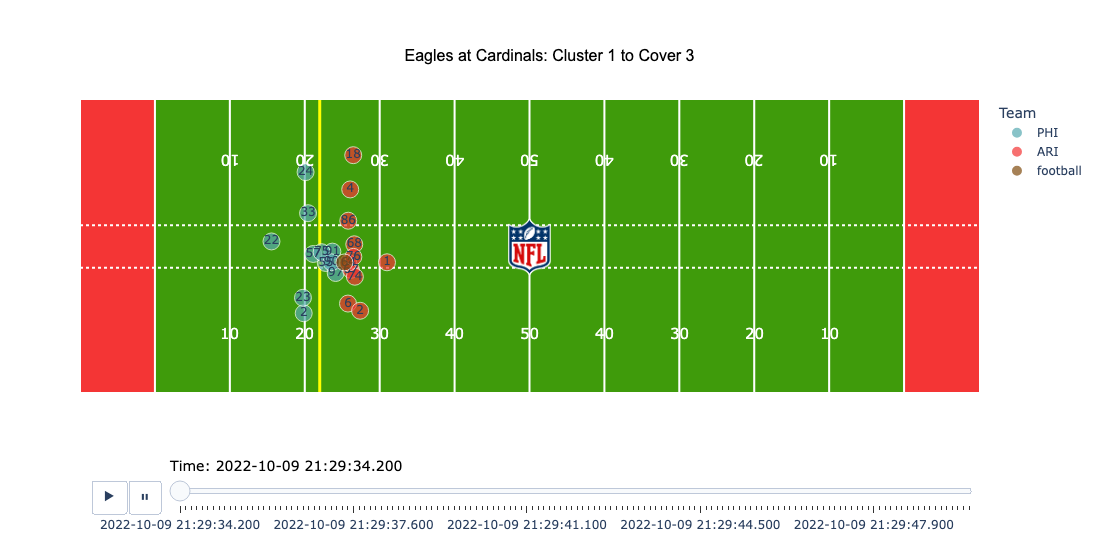

In [819]:
#Example of Cluster 1

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Assuming df_weeks_game3 is your DataFrame
df_weeks_game1 = df_weeks_game1.loc[df_weeks_game1['time'].notnull()]
df_weeks_game1['time_str'] = df_weeks_game1['time'].astype(str)  # Convert time to string for Plotly

# Create scatter plot with animation
fig = px.scatter(
    df_weeks_game1,
    x='x',
    y='y',
    animation_frame='time_str',
    color='club',
    size=[1] * len(df_weeks_game1),  # Set dot sizes
    size_max=12,
    text='jerseyNumber',  # Add jersey numbers as text labels
    range_x=[0, 120],
    range_y=[0, 53.3],
    title='Eagles at Cardinals: Cluster 1 to Cover 3',
    color_discrete_map={'football': '#814d0f', 'PHI': '#58aab2', 'ARI': '#f43535'}  # Set colors for dots
)
# Center the title and customize the font
fig.update_layout(
    title={
        'x': 0.5,  # Center title horizontally
        'xanchor': 'center',  # Ensure it aligns correctly
        'yanchor': 'top',  # Top alignment for title
        'font': {
            'family': 'Arial, sans-serif',  # Change font family
            'size': 16,  # Set font size
            'color': 'black'  # Set font color
        }
    }
)
# Customize layout to resemble a football field
fig.update_layout(
    xaxis_title="",
    yaxis_title="",
    plot_bgcolor="#3f9b0b",  # Set field color
    xaxis=dict(
        showticklabels=False,  # Remove x-axis labels
        gridcolor="white",  # Vertical grid lines for yard markers
        tickvals=list(range(0, 121, 10)),  # Tick marks every 10 yards
        ticktext=[f"{i}" for i in range(0, 121, 10)],
    ),
    yaxis=dict(
        showgrid=False,  # Disable horizontal grid lines
        showticklabels=False  # No ticks on the y-axis
    ),
    height=550,  # Adjust height
    width=750,  # Adjust width
    legend_title_text="Team",  # Set legend title
)

# Add darker green end zones
fig.add_shape(
    type="rect",
    x0=0,
    x1=10,
    y0=0,
    y1=53.3,
    fillcolor="#f43535",  # endzone
    opacity=1,
    layer="below",
    line_width=0,
)
fig.add_shape(
    type="rect",
    x0=110,
    x1=120,
    y0=0,
    y1=53.3,
    fillcolor="#f43535",  # endzone
    opacity=1,
    layer="below",
    line_width=0,
)

# Add vertical yard markers
for x in range(10, 111, 10):
    fig.add_shape(
        type="line",
        x0=x,
        x1=x,
        y0=0,
        y1=53.3,
        line=dict(color="white", width=2),
        layer="below"
    )

# Add a yellow line at x = 52
fig.add_shape(
    type="line",
    x0=32,
    x1=32,
    y0=0,
    y1=53.3,
    line=dict(color="yellow", width=3),  # Yellow color
    layer="below"
)


# Add dotted white horizontal lines
fig.add_shape(
    type="line",
    x0=0,
    x1=120,
    y0=22.8,
    y1=22.8,
    line=dict(color="white", width=2, dash="dot"),  # Dotted white line
    layer="below"
)

# Add dotted white horizontal lines
fig.add_shape(
    type="line",
    x0=0,
    x1=120,
    y0=30.5,
    y1=30.5,
    line=dict(color="white", width=2, dash="dot"),  # Dotted white line
    layer="below"
)
# Add yard marker annotations
yard_markers = {
    20: "10", 30: "20", 40: "30", 50: "40",
    60: "50", 70: "40", 80: "30", 90: "20", 100: "10"
}
for x, text in yard_markers.items():
    fig.add_annotation(
        x=x,
        y=11,  # Fixed y coordinate for text placement
        text=text,
        showarrow=False,
        font=dict(color="white", size=15),  # White font
        align="center"
    )


for x, text in yard_markers.items():
    fig.add_annotation(
        x=x,
        y=42.2,  # Fixed y coordinate for text placement
        text=text,
        showarrow=False,
        font=dict(color="white", size=15),  # White font
        align="center",
        textangle=180
    )
# Add the NFL logo image to the center of the field
fig.update_layout(
    images=[
        dict(
            source="https://upload.wikimedia.org/wikipedia/en/a/a2/National_Football_League_logo.svg", 
            x=0.5,  # Center of the field (normalized coordinate: 0 to 1)
            y=0.5,  # Center of the field (normalized coordinate: 0 to 1)
            xref="paper",  # Reference x-axis in normalized coordinates
            yref="paper",  # Reference y-axis in normalized coordinates
            sizex=0.2,  # Width of the image (relative to the plot)
            sizey=0.2,  # Height of the image (relative to the plot)
            xanchor="center",  # Align image to its center on x
            yanchor="middle",  # Align image to its center on y
            layer="above"  # Place the image below the data
        )
    ]
)

# Customize Play/Pause buttons
fig.update_layout(
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 50, 'redraw': True}, 'fromcurrent': True}],
                'label': '▶',  # Play icon
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': '⏸',  # Pause icon
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }]
)

# Rename the animation label above the slider
fig.update_layout(
    sliders=[{
        'currentvalue': {
            'prefix': 'Time: ',  # Change "time_str:" to "time:"
            'font': {'size': 14, 'color': 'black'}
        }
    }]
)
# Ensure dots are on top by adjusting the z-order of the scatter plot trace
fig.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=2, color="DarkSlateGrey")), selector=dict(mode="markers"), z=101)
# Show the plot
fig.show()

# Cluster 2: Rock n’ Roll
Just as a rock song can stand out with a great guitar solo, the solo DB stands out in the Cluster 2 alignment.  Here, in addition to one deep safety, a pre-snap motion is shadowed by the Saints DB. Tom Brady likes the outside 1 on 1 matchup with his wide receiver, Breshad Perriman, who catches the 4th quarter go-ahead touchdown. 

In [737]:
#Example of Cluster 2

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Assuming df_weeks_game3 is your DataFrame
df_weeks_game2 = df_weeks_game2.loc[df_weeks_game2['time'].notnull()]
df_weeks_game2['time_str'] = df_weeks_game2['time'].astype(str)  # Convert time to string for Plotly

# Create scatter plot with animation
fig = px.scatter(
    df_weeks_game2,
    x='x',
    y='y',
    animation_frame='time_str',
    color='club',
    size=[1] * len(df_weeks_game2),  # Set dot sizes
    size_max=12,
    text='jerseyNumber',  # Add jersey numbers as text labels
    range_x=[0, 120],
    range_y=[0, 53.3],
    title='Bucs at Saints: Cluster 2 to Cover 1',
    color_discrete_map={'football': '#814d0f', 'TB': '#df4848', 'NO': '#D3BC8D'}  # Set colors for dots
)
# Center the title and customize the font
fig.update_layout(
    title={
        'x': 0.5,  # Center title horizontally
        'xanchor': 'center',  # Ensure it aligns correctly
        'yanchor': 'top',  # Top alignment for title
        'font': {
            'family': 'Arial, sans-serif',  # Change font family
            'size': 16,  # Set font size
            'color': 'black'  # Set font color
        }
    }
)
# Customize layout to resemble a football field
fig.update_layout(
    xaxis_title="",
    yaxis_title="",
    plot_bgcolor="#3f9b0b",  # Set field color
    xaxis=dict(
        showticklabels=False,  # Remove x-axis labels
        gridcolor="white",  # Vertical grid lines for yard markers
        tickvals=list(range(0, 121, 10)),  # Tick marks every 10 yards
        ticktext=[f"{i}" for i in range(0, 121, 10)],
    ),
    yaxis=dict(
        showgrid=False,  # Disable horizontal grid lines
        showticklabels=False  # No ticks on the y-axis
    ),
    height=550,  # Adjust height
    width=750,  # Adjust width
    legend_title_text="Team",  # Set legend title
)

# Add darker green end zones
fig.add_shape(
    type="rect",
    x0=0,
    x1=10,
    y0=0,
    y1=53.3,
    fillcolor="#D3BC8D",  # endzone
    opacity=1,
    layer="below",
    line_width=0,
)
fig.add_shape(
    type="rect",
    x0=110,
    x1=120,
    y0=0,
    y1=53.3,
    fillcolor="#D3BC8D",  # endzone
    opacity=1,
    layer="below",
    line_width=0,
)

# Add vertical yard markers
for x in range(10, 111, 10):
    fig.add_shape(
        type="line",
        x0=x,
        x1=x,
        y0=0,
        y1=53.3,
        line=dict(color="white", width=2),
        layer="below"
    )

# Add a yellow line at x = 52
fig.add_shape(
    type="line",
    x0=33,
    x1=33,
    y0=0,
    y1=53.3,
    line=dict(color="yellow", width=3),  # Yellow color
    layer="below"
)


# Add dotted white horizontal lines
fig.add_shape(
    type="line",
    x0=0,
    x1=120,
    y0=22.8,
    y1=22.8,
    line=dict(color="white", width=2, dash="dot"),  # Dotted white line
    layer="below"
)

# Add dotted white horizontal lines
fig.add_shape(
    type="line",
    x0=0,
    x1=120,
    y0=30.5,
    y1=30.5,
    line=dict(color="white", width=2, dash="dot"),  # Dotted white line
    layer="below"
)
# Add yard marker annotations
yard_markers = {
    20: "10", 30: "20", 40: "30", 50: "40",
    60: "50", 70: "40", 80: "30", 90: "20", 100: "10"
}
for x, text in yard_markers.items():
    fig.add_annotation(
        x=x,
        y=11,  # Fixed y coordinate for text placement
        text=text,
        showarrow=False,
        font=dict(color="white", size=15),  # White font
        align="center"
    )


for x, text in yard_markers.items():
    fig.add_annotation(
        x=x,
        y=42.2,  # Fixed y coordinate for text placement
        text=text,
        showarrow=False,
        font=dict(color="white", size=15),  # White font
        align="center",
        textangle=180
    )
# Add the NFL logo image to the center of the field
fig.update_layout(
    images=[
        dict(
            source="https://upload.wikimedia.org/wikipedia/en/a/a2/National_Football_League_logo.svg", 
            x=0.5,  # Center of the field (normalized coordinate: 0 to 1)
            y=0.5,  # Center of the field (normalized coordinate: 0 to 1)
            xref="paper",  # Reference x-axis in normalized coordinates
            yref="paper",  # Reference y-axis in normalized coordinates
            sizex=0.2,  # Width of the image (relative to the plot)
            sizey=0.2,  # Height of the image (relative to the plot)
            xanchor="center",  # Align image to its center on x
            yanchor="middle",  # Align image to its center on y
            layer="above"  # Place the image below the data
        )
    ]
)

# Customize Play/Pause buttons
fig.update_layout(
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 50, 'redraw': True}, 'fromcurrent': True}],
                'label': '▶',  # Play icon
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': '⏸',  # Pause icon
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }]
)

# Rename the animation label above the slider
fig.update_layout(
    sliders=[{
        'currentvalue': {
            'prefix': 'Time: ',  # Change "time_str:" to "time:"
            'font': {'size': 14, 'color': 'black'}
        }
    }]
)
# Ensure dots are on top by adjusting the z-order of the scatter plot trace
fig.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=2, color="DarkSlateGrey")), selector=dict(mode="markers"), z=101)
# Show the plot
fig.show()

#### Cluster 3: Classical Music
This alignment is structured in a methodical way, much like classical music.  Compared to Clusters 1 and 2, several coverages are within the norm from this alignment.  In this play, the Bears drop into a Cover 2.  DB #22 Kindle Vindor is pressed on his receiver much like CB's in the previous play, but he ultimately covers his zone to perfection and grabs the interception.  


In [739]:
#Example of Cluster 3

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Assuming df_weeks_game3 is your DataFrame
df_weeks_game3 = df_weeks_game3.loc[df_weeks_game3['time'].notnull()]
df_weeks_game3['time_str'] = df_weeks_game3['time'].astype(str)  # Convert time to string for Plotly

# Create scatter plot with animation
fig = px.scatter(
    df_weeks_game3,
    x='x',
    y='y',
    animation_frame='time_str',
    color='club',
    size=[1] * len(df_weeks_game3),  # Set dot sizes
    size_max=12,
    text='jerseyNumber',  # Add jersey numbers as text labels
    range_x=[0, 120],
    range_y=[0, 53.3],
    title='Bears at Vikings: Cluster 3 to Cover 2',
    color_discrete_map={'football': '#814d0f', 'CHI': '#C83803', 'MIN': '#c326fa'}  # Set colors for dots
)

# Center the title and customize the font
fig.update_layout(
    title={
        'x': 0.5,  # Center title horizontally
        'xanchor': 'center',  # Ensure it aligns correctly
        'yanchor': 'top',  # Top alignment for title
        'font': {
            'family': 'Arial, sans-serif',  # Change font family
            'size': 16,  # Set font size
            'color': 'black'  # Set font color
        }
    }
)

# Customize layout to resemble a football field
fig.update_layout(
    xaxis_title="",
    yaxis_title="",
    plot_bgcolor="#3f9b0b",  # Set field color
    xaxis=dict(
        showticklabels=False,  # Remove x-axis labels
        gridcolor="white",  # Vertical grid lines for yard markers
        tickvals=list(range(0, 121, 10)),  # Tick marks every 10 yards
        ticktext=[f"{i}" for i in range(0, 121, 10)],
    ),
    yaxis=dict(
        showgrid=False,  # Disable horizontal grid lines
        showticklabels=False  # No ticks on the y-axis
    ),
    height=550,  # Adjust height
    width=750,  # Adjust width
    legend_title_text="Team",  # Set legend title
)

# Add darker green end zones
fig.add_shape(
    type="rect",
    x0=0,
    x1=10,
    y0=0,
    y1=53.3,
    fillcolor="#9f19ce",  # endzone
    opacity=1,
    layer="below",
    line_width=0,
)
fig.add_shape(
    type="rect",
    x0=110,
    x1=120,
    y0=0,
    y1=53.3,
    fillcolor="#9f19ce",  # endzone
    opacity=1,
    layer="below",
    line_width=0,
)

# Add vertical yard markers
for x in range(10, 111, 10):
    fig.add_shape(
        type="line",
        x0=x,
        x1=x,
        y0=0,
        y1=53.3,
        line=dict(color="white", width=2),
        layer="below"
    )

# Add a yellow line at x = 52
fig.add_shape(
    type="line",
    x0=78,
    x1=78,
    y0=0,
    y1=53.3,
    line=dict(color="yellow", width=3),  # Yellow color
    layer="below"
)


# Add dotted white horizontal lines
fig.add_shape(
    type="line",
    x0=0,
    x1=120,
    y0=22.8,
    y1=22.8,
    line=dict(color="white", width=2, dash="dot"),  # Dotted white line
    layer="below"
)

# Add dotted white horizontal lines
fig.add_shape(
    type="line",
    x0=0,
    x1=120,
    y0=30.5,
    y1=30.5,
    line=dict(color="white", width=2, dash="dot"),  # Dotted white line
    layer="below"
)
# Add yard marker annotations
yard_markers = {
    20: "10", 30: "20", 40: "30", 50: "40",
    60: "50", 70: "40", 80: "30", 90: "20", 100: "10"
}
for x, text in yard_markers.items():
    fig.add_annotation(
        x=x,
        y=11,  # Fixed y coordinate for text placement
        text=text,
        showarrow=False,
        font=dict(color="white", size=15),  # White font
        align="center"
    )


for x, text in yard_markers.items():
    fig.add_annotation(
        x=x,
        y=42.2,  # Fixed y coordinate for text placement
        text=text,
        showarrow=False,
        font=dict(color="white", size=15),  # White font
        align="center",
        textangle=180
    )
# Add the NFL logo image to the center of the field
fig.update_layout(
    images=[
        dict(
            source="https://upload.wikimedia.org/wikipedia/en/a/a2/National_Football_League_logo.svg",  # Replace with the URL of the NFL logo
            x=0.5,  # Center of the field (normalized coordinate: 0 to 1)
            y=0.5,  # Center of the field (normalized coordinate: 0 to 1)
            xref="paper",  # Reference x-axis in normalized coordinates
            yref="paper",  # Reference y-axis in normalized coordinates
            sizex=0.2,  # Width of the image (relative to the plot)
            sizey=0.2,  # Height of the image (relative to the plot)
            xanchor="center",  # Align image to its center on x
            yanchor="middle",  # Align image to its center on y
            layer="below"  # Place the image below the data
        )
    ]
)

# Customize Play/Pause buttons
fig.update_layout(
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 50, 'redraw': True}, 'fromcurrent': True}],
                'label': '▶',  # Play icon
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': '⏸',  # Pause icon
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }]
)

# Rename the animation label above the slider
fig.update_layout(
    sliders=[{
        'currentvalue': {
            'prefix': 'Time: ',  # Change "time_str:" to "time:"
            'font': {'size': 14, 'color': 'black'}
        }
    }]
)

# Ensure dots are on top by adjusting the z-order of the scatter plot trace
fig.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=2, color="DarkSlateGrey")), selector=dict(mode="markers"), z=101)
# Show the plot
fig.show()

# Cluster 4:  Electronic
While electronic music is versatile to a variety of different tones, beats, and rhythms, this alignment follows suit by being the most versatile to coverage variety.  Cover 2, Quarters, and Cover 6 are not represented as the most common coverage for any cluster, but this cluster would be closest for all 3.  In the below case, the Bengals show 2 deep backs, are not pressing any receivers until the final second, and drop into Quarters. Tua Tagovailoa hits Tyreek Hill on the center deep ball, nicely find the gap in coverage.

In [741]:
#Example of Cluster 4

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Assuming df_weeks_game5 is your DataFrame
df_weeks_game4 = df_weeks_game4.loc[df_weeks_game4['time'].notnull()]
df_weeks_game4['time_str'] = df_weeks_game4['time'].astype(str)  # Convert time to string for Plotly

# Create scatter plot with animation
fig = px.scatter(
    df_weeks_game4,
    x='x',
    y='y',
    animation_frame='time_str',
    color='club',
    size=[1] * len(df_weeks_game4),  # Set dot sizes
    size_max=12,
    text='jerseyNumber',  # Add jersey numbers as text labels
    range_x=[0, 120],
    range_y=[0, 53.3],
    title='Dolphins at Bengals: Cluster 4 to Quarters',
    color_discrete_map={'football': '#814d0f', 'CIN': '#FB4F14', 'MIA': '#09f6fa'}  # Set colors for dots
)
# Center the title and customize the font
fig.update_layout(
    title={
        'x': 0.5,  # Center title horizontally
        'xanchor': 'center',  # Ensure it aligns correctly
        'yanchor': 'top',  # Top alignment for title
        'font': {
            'family': 'Arial, sans-serif',  # Change font family
            'size': 16,  # Set font size
            'color': 'black'  # Set font color
        }
    }
)
# Customize layout to resemble a football field
fig.update_layout(
    xaxis_title="",
    yaxis_title="",
    plot_bgcolor="#3f9b0b",  # Set field color
    xaxis=dict(
        showticklabels=False,  # Remove x-axis labels
        gridcolor="white",  # Vertical grid lines for yard markers
        tickvals=list(range(0, 121, 10)),  # Tick marks every 10 yards
        ticktext=[f"{i}" for i in range(0, 121, 10)],
    ),
    yaxis=dict(
        showgrid=False,  # Disable horizontal grid lines
        showticklabels=False  # No ticks on the y-axis
    ),
    height=550,  # Adjust height
    width=750,  # Adjust width
    legend_title_text="Team",  # Set legend title
)

# Add darker green end zones
fig.add_shape(
    type="rect",
    x0=0,
    x1=10,
    y0=0,
    y1=53.3,
    fillcolor="#FB4F14",  # endzone
    opacity=1,
    layer="below",
    line_width=0,
)
fig.add_shape(
    type="rect",
    x0=110,
    x1=120,
    y0=0,
    y1=53.3,
    fillcolor="#FB4F14",  # endzone
    opacity=1,
    layer="below",
    line_width=0,
)

# Add vertical yard markers
for x in range(10, 111, 10):
    fig.add_shape(
        type="line",
        x0=x,
        x1=x,
        y0=0,
        y1=53.3,
        line=dict(color="white", width=2),
        layer="below"
    )

# Add a yellow line at x = 52
fig.add_shape(
    type="line",
    x0=69,
    x1=69,
    y0=0,
    y1=53.3,
    line=dict(color="yellow", width=3),  # Yellow color
    layer="below"
)

# Add dotted white horizontal lines
fig.add_shape(
    type="line",
    x0=0,
    x1=120,
    y0=22.8,
    y1=22.8,
    line=dict(color="white", width=2, dash="dot"),  # Dotted white line
    layer="below"
)

# Add dotted white horizontal lines
fig.add_shape(
    type="line",
    x0=0,
    x1=120,
    y0=30.5,
    y1=30.5,
    line=dict(color="white", width=2, dash="dot"),  # Dotted white line
    layer="below"
)
# Add yard marker annotations
yard_markers = {
    20: "10", 30: "20", 40: "30", 50: "40",
    60: "50", 70: "40", 80: "30", 90: "20", 100: "10"
}
for x, text in yard_markers.items():
    fig.add_annotation(
        x=x,
        y=11,  # Fixed y coordinate for text placement
        text=text,
        showarrow=False,
        font=dict(color="white", size=15),  # White font
        align="center"
    )


for x, text in yard_markers.items():
    fig.add_annotation(
        x=x,
        y=42.2,  # Fixed y coordinate for text placement
        text=text,
        showarrow=False,
        font=dict(color="white", size=15),  # White font
        align="center",
        textangle=180
    )
# Add the NFL logo image to the center of the field
fig.update_layout(
    images=[
        dict(
            source="https://upload.wikimedia.org/wikipedia/en/a/a2/National_Football_League_logo.svg",  # Replace with the URL of the NFL logo
            x=0.5,  # Center of the field (normalized coordinate: 0 to 1)
            y=0.5,  # Center of the field (normalized coordinate: 0 to 1)
            xref="paper",  # Reference x-axis in normalized coordinates
            yref="paper",  # Reference y-axis in normalized coordinates
            sizex=0.2,  # Width of the image (relative to the plot)
            sizey=0.2,  # Height of the image (relative to the plot)
            xanchor="center",  # Align image to its center on x
            yanchor="middle",  # Align image to its center on y
            layer="below"  # Place the image below the data
        )
    ]
)

# Customize Play/Pause buttons
fig.update_layout(
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 50, 'redraw': True}, 'fromcurrent': True}],
                'label': '▶',  # Play icon
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': '⏸',  # Pause icon
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }]
)

# Rename the animation label above the slider
fig.update_layout(
    sliders=[{
        'currentvalue': {
            'prefix': 'Time: ',  # Change "time_str:" to "time:"
            'font': {'size': 14, 'color': 'black'}
        }
    }]
)
# Ensure dots are on top by adjusting the z-order of the scatter plot trace
fig.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=2, color="DarkSlateGrey")), selector=dict(mode="markers"), z=101)
# Show the plot
fig.show()

# DISCO with a Pre Snap Motion

While the previous examples showed a non-DISCO play for each cluster, the following example demonstrates how the Broncos disguised a Cover 1 from Cluster 4.  In this case, the Jets motion a receiver across the field.  There is some subtle movement from the DB's but considering no defensive player directly followed the receiver in motion and we observe 2 deep backs on each side of the field, Cluster 4 is the classified alignement.  Within a second of the snap (after our timestamp for measuring an alignment cluster), the Broncos alignment starts to shift towards Cluster 1.  When the play is in action, we see 1 safety drop back deep middle, and the other defenders immediately find their man assignment.

In [743]:
#Example of Motion 

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Assuming df_weeks_game5 is your DataFrame
df_weeks_game5 = df_weeks_game5.loc[df_weeks_game5['time'].notnull()]
df_weeks_game5['time_str'] = df_weeks_game5['time'].astype(str)  # Convert time to string for Plotly

# Create scatter plot with animation
fig = px.scatter(
    df_weeks_game5,
    x='x',
    y='y',
    animation_frame='time_str',
    color='club',
    size=[1] * len(df_weeks_game5),  # Set dot sizes
    size_max=12,
    text='jerseyNumber',  # Add jersey numbers as text labels
    range_x=[0, 120],
    range_y=[0, 53.3],
    title='Jets at Broncos: Cluster 4 to Cover 1',
    color_discrete_map={'football': '#814d0f', 'NYJ': '#6ca893', 'DEN': '#FB4F14'}  # Set colors for dots
)
# Center the title and customize the font
fig.update_layout(
    title={
        'x': 0.5,  # Center title horizontally
        'xanchor': 'center',  # Ensure it aligns correctly
        'yanchor': 'top',  # Top alignment for title
        'font': {
            'family': 'Arial, sans-serif',  # Change font family
            'size': 16,  # Set font size
            'color': 'black'  # Set font color
        }
    }
)
# Customize layout to resemble a football field
fig.update_layout(
    xaxis_title="",
    yaxis_title="",
    plot_bgcolor="#3f9b0b",  # Set field color
    xaxis=dict(
        showticklabels=False,  # Remove x-axis labels
        gridcolor="white",  # Vertical grid lines for yard markers
        tickvals=list(range(0, 121, 10)),  # Tick marks every 10 yards
        ticktext=[f"{i}" for i in range(0, 121, 10)],
    ),
    yaxis=dict(
        showgrid=False,  # Disable horizontal grid lines
        showticklabels=False  # No ticks on the y-axis
    ),
    height=550,  # Adjust height
    width=750,  # Adjust width
    legend_title_text="Team",  # Set legend title
)

# Add darker green end zones
fig.add_shape(
    type="rect",
    x0=0,
    x1=10,
    y0=0,
    y1=53.3,
    fillcolor="#FB4F14",  # endzone
    opacity=1,
    layer="below",
    line_width=0,
)
fig.add_shape(
    type="rect",
    x0=110,
    x1=120,
    y0=0,
    y1=53.3,
    fillcolor="#FB4F14",  # endzone
    opacity=1,
    layer="below",
    line_width=0,
)

# Add vertical yard markers
for x in range(10, 111, 10):
    fig.add_shape(
        type="line",
        x0=x,
        x1=x,
        y0=0,
        y1=53.3,
        line=dict(color="white", width=2),
        layer="below"
    )

# Add a yellow line at x = 52
fig.add_shape(
    type="line",
    x0=52,
    x1=52,
    y0=0,
    y1=53.3,
    line=dict(color="yellow", width=3),  # Yellow color
    layer="below"
)

# Add dotted white horizontal lines
fig.add_shape(
    type="line",
    x0=0,
    x1=120,
    y0=22.8,
    y1=22.8,
    line=dict(color="white", width=2, dash="dot"),  # Dotted white line
    layer="below"
)

# Add dotted white horizontal lines
fig.add_shape(
    type="line",
    x0=0,
    x1=120,
    y0=30.5,
    y1=30.5,
    line=dict(color="white", width=2, dash="dot"),  # Dotted white line
    layer="below"
)
# Add yard marker annotations
yard_markers = {
    20: "10", 30: "20", 40: "30", 50: "40",
    60: "50", 70: "40", 80: "30", 90: "20", 100: "10"
}
for x, text in yard_markers.items():
    fig.add_annotation(
        x=x,
        y=11,  # Fixed y coordinate for text placement
        text=text,
        showarrow=False,
        font=dict(color="white", size=15),  # White font
        align="center"
    )


for x, text in yard_markers.items():
    fig.add_annotation(
        x=x,
        y=42.2,  # Fixed y coordinate for text placement
        text=text,
        showarrow=False,
        font=dict(color="white", size=15),  # White font
        align="center",
        textangle=180
    )
# Add the NFL logo image to the center of the field
fig.update_layout(
    images=[
        dict(
            source="https://upload.wikimedia.org/wikipedia/en/a/a2/National_Football_League_logo.svg",  # Replace with the URL of the NFL logo
            x=0.5,  # Center of the field (normalized coordinate: 0 to 1)
            y=0.5,  # Center of the field (normalized coordinate: 0 to 1)
            xref="paper",  # Reference x-axis in normalized coordinates
            yref="paper",  # Reference y-axis in normalized coordinates
            sizex=0.2,  # Width of the image (relative to the plot)
            sizey=0.2,  # Height of the image (relative to the plot)
            xanchor="center",  # Align image to its center on x
            yanchor="middle",  # Align image to its center on y
            layer="below"  # Place the image below the data
        )
    ]
)

# Customize Play/Pause buttons
fig.update_layout(
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 50, 'redraw': True}, 'fromcurrent': True}],
                'label': '▶',  # Play icon
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': '⏸',  # Pause icon
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }]
)

# Rename the animation label above the slider
fig.update_layout(
    sliders=[{
        'currentvalue': {
            'prefix': 'Time: ',  # Change "time_str:" to "time:"
            'font': {'size': 14, 'color': 'black'}
        }
    }]
)
# Ensure dots are on top by adjusting the z-order of the scatter plot trace
fig.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=2, color="DarkSlateGrey")), selector=dict(mode="markers"), z=101)
# Show the plot
fig.show()

# DISCO Results

For the DISCO metric, we define a disguise as a transformation from a given cluster to a pass coverage that has less than a 10% outcome, such as going into a Quarters coverage from Cluster 2.  A disguise can also be identified as dealing with a pre-snap motion opposite to coverage norms, such as a defender following closely a man in motion to eventually drop into coverage once the ball is snapped.  The below chart displays the frequency of snaps a team’s defense disguises coverage (weeks 1-9 in NFL 2022-23 season), as well as a breakdown of frequencies relative to each cluster for that team.   While the Vikings used DISCO more frequently than any other team, the Jaguars used a Cluster 2 disguise at the highest rate.  With further analysis, it may also be determined how teams prefer to move into specific coverages, depending on their personnel and other factors.

Note - Plays under 2 minutes in a half or during 3-score games in the 2nd half are excluded from eligibility, as we found DISCO plays are extremely uncommon in those situations. 

In [746]:
####
#Strategic ALignment Transformation % (disco)
##disco - Presnap Expected Points

#Fix graphs so numbers are behind players and logo is behind players


In [747]:
df_team_disco = df_features.groupby(
   ['club'] 
).agg(
    {
        'disco': 'mean'
    }
).reset_index().sort_values(by = 'disco', ascending = False)
#df_team_disco = df_team_disco.pivot(index=['club'], columns='coverage_cluster_cat', values=['disco'])


df_team_disco_clusters = df_features.groupby(
   ['club', 'coverage_cluster_cat'] 
).agg(
    {
        'disco': 'mean'
    }
).reset_index().sort_values(by = 'disco', ascending = False)
df_team_disco_clusters = df_team_disco_clusters.pivot(index=['club'], columns='coverage_cluster_cat', values=['disco']).reset_index()
df_team_disco_clusters.columns = [''.join(map(str, col)) if isinstance(col, tuple) else col for col in df_team_disco_clusters.columns]
df_team_disco = pd.merge(df_team_disco, df_team_disco_clusters, on = 'club', how = 'inner')
df_team_disco = df_team_disco[['club', 'disco', 'disco1', 'disco2', 'disco3', 'disco4']]
#df_team_disco

In [748]:
# Create a DataFrame with all 32 NFL teams and their logo URLs
logos = pd.DataFrame({
    'club': [
        'ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 
        'GB', 'HOU', 'IND', 'JAX', 'KC', 'LAC', 'LA', 'LV', 'MIA', 'MIN', 'NE', 
        'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SF', 'SEA', 'TB', 'TEN', 'WAS'
    ],
    'logo_url': [
        'https://upload.wikimedia.org/wikipedia/en/7/72/Arizona_Cardinals_logo.svg',  # ARI
        'https://upload.wikimedia.org/wikipedia/en/c/c5/Atlanta_Falcons_logo.svg',  # ATL
        'https://upload.wikimedia.org/wikipedia/en/1/16/Baltimore_Ravens_logo.svg',  # BAL
        'https://upload.wikimedia.org/wikipedia/en/7/77/Buffalo_Bills_logo.svg',  # BUF
        'https://upload.wikimedia.org/wikipedia/en/1/1c/Carolina_Panthers_logo.svg',  # CAR
        'https://upload.wikimedia.org/wikipedia/commons/5/5c/Chicago_Bears_logo.svg',  # CHI
        'https://upload.wikimedia.org/wikipedia/commons/8/81/Cincinnati_Bengals_logo.svg',  # CIN
        'https://upload.wikimedia.org/wikipedia/en/d/d9/Cleveland_Browns_logo.svg',  # CLE
        'https://upload.wikimedia.org/wikipedia/commons/1/15/Dallas_Cowboys.svg',  # DAL
        'https://upload.wikimedia.org/wikipedia/en/4/44/Denver_Broncos_logo.svg',  # DEN
        'https://upload.wikimedia.org/wikipedia/en/7/71/Detroit_Lions_logo.svg',  # DET
        'https://upload.wikimedia.org/wikipedia/commons/5/50/Green_Bay_Packers_logo.svg',  # GB
        'https://upload.wikimedia.org/wikipedia/en/2/28/Houston_Texans_logo.svg',  # HOU
        'https://upload.wikimedia.org/wikipedia/commons/0/00/Indianapolis_Colts_logo.svg',  # IND
        'https://upload.wikimedia.org/wikipedia/en/7/74/Jacksonville_Jaguars_logo.svg',  # JAX
        'https://upload.wikimedia.org/wikipedia/en/e/e1/Kansas_City_Chiefs_logo.svg',  # KC
        'https://upload.wikimedia.org/wikipedia/commons/thumb/a/a6/Los_Angeles_Chargers_logo.svg/100px-Los_Angeles_Chargers_logo.svg.png',  # LAC
        'https://upload.wikimedia.org/wikipedia/en/8/8a/Los_Angeles_Rams_logo.svg',  # LA
        'https://upload.wikimedia.org/wikipedia/en/thumb/4/48/Las_Vegas_Raiders_logo.svg/1280px-Las_Vegas_Raiders_logo.svg.png',  # LV
        'https://upload.wikimedia.org/wikipedia/en/3/37/Miami_Dolphins_logo.svg',  # MIA
        'https://upload.wikimedia.org/wikipedia/en/4/48/Minnesota_Vikings_logo.svg',  # MIN
        'https://upload.wikimedia.org/wikipedia/en/b/b9/New_England_Patriots_logo.svg',  # NE
        'https://upload.wikimedia.org/wikipedia/commons/5/50/New_Orleans_Saints_logo.svg',  # NO
        'https://upload.wikimedia.org/wikipedia/commons/6/60/New_York_Giants_logo.svg',  # NYG
        'https://upload.wikimedia.org/wikipedia/en/6/6b/New_York_Jets_logo.svg',  # NYJ
        'https://upload.wikimedia.org/wikipedia/en/8/8e/Philadelphia_Eagles_logo.svg',  # PHI
        'https://upload.wikimedia.org/wikipedia/commons/d/de/Pittsburgh_Steelers_logo.svg',  # PIT
        'https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/San_Francisco_49ers_logo.svg/2560px-San_Francisco_49ers_logo.svg.png',  # SF
        'https://upload.wikimedia.org/wikipedia/en/8/8e/Seattle_Seahawks_logo.svg',  # SEA
        'https://upload.wikimedia.org/wikipedia/en/a/a2/Tampa_Bay_Buccaneers_logo.svg',  # TB
        'https://upload.wikimedia.org/wikipedia/en/c/c1/Tennessee_Titans_logo.svg',  # TEN
        'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0c/Washington_Commanders_logo.svg/2560px-Washington_Commanders_logo.svg.png',  # WAS
    ]
})


# Merge df_team_disco with logos DataFrame
df_team_disco1 = pd.merge(df_team_disco, logos, on='club', how='left')

# Rename columns
df_team_disco1 = df_team_disco1.rename(columns={
    'club': 'Team', 
    'disco': 'DISCO %', 
    'disco1': 'DISCO Cluster 1 %', 
    'disco2': 'DISCO Cluster 2 %', 
    'disco3': 'DISCO Cluster 3 %',
    'disco4': 'DISCO Cluster 4 %'
})

# Merge the logo and team into one column
df_team_disco1['Team'] = ''
df_team_disco1['Team'] = df_team_disco1.apply(
    lambda row: f'<img src="{row["logo_url"]}" style="height:30px; padding-right: 10px;">{row["Team"]}',
    axis=1
)

# Drop the original 'logo_url' and 'Team' columns
df_team_disco1 = df_team_disco1.drop(columns=['logo_url'])

# Format disco columns as percentages with rounding to the nearest whole number
df_team_disco1['DISCO %'] = df_team_disco1['DISCO %'].apply(lambda x: f"{round(x*100)}%")
df_team_disco1['DISCO Cluster 1 %'] = df_team_disco1['DISCO Cluster 1 %'].apply(lambda x: f"{round(x*100)}%")
df_team_disco1['DISCO Cluster 2 %'] = df_team_disco1['DISCO Cluster 2 %'].apply(lambda x: f"{round(x*100)}%")
df_team_disco1['DISCO Cluster 3 %'] = df_team_disco1['DISCO Cluster 3 %'].apply(lambda x: f"{round(x*100)}%")
df_team_disco1['DISCO Cluster 4 %'] = df_team_disco1['DISCO Cluster 4 %'].apply(lambda x: f"{round(x*100)}%")

# Reorder columns so the new merged column is first
df_team_disco1 = df_team_disco1[['Team', 'DISCO %', 'DISCO Cluster 1 %', 'DISCO Cluster 2 %', 'DISCO Cluster 3 %', 'DISCO Cluster 4 %']]

# Use Pandas styling to display the merged column and format the DataFrame
df_team_disco_styled = df_team_disco1.style.format({
    'Logo and Team': lambda x: x  # Keep the merged column as is
}).hide(axis='index')  # Hide the default index

# Set table styles to ensure correct alignment and appearance
df_team_disco_styled.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('background-color', '#f4f4f4'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('text-align', 'center')]},
])#.set_properties(**{'border': '1px solid black', 'padding': '5px'})

# Use Pandas styling to display the logos and format the DataFrame
def render_logo(url):
    return f'<img src="{url}" style="height:30px;">'


# Set table styles to ensure correct alignment, appearance, and alternating row colors
df_team_disco_styled.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('background-color', '#013369'), 
                                 ('font-weight', 'bold'), ('color', 'white')]},  # Make column label text white
    {'selector': 'td', 'props': [('text-align', 'center'), ('font-size', '16px')]},  # Adjust font size here
    {'selector': 'tr:nth-child(aeven)', 'props': [('background-color', '#f9f9f9')]},  # Lighter grey for even rows
    {'selector': 'tr:nth-child(odd)', 'props': [('background-color', 'white')]},   # Default grey for odd rows
], overwrite=False).set_properties(**{'border': 'none', 'padding': '7px'})  # Remove the borders

# Display the styled DataFrame with the merged column
from IPython.display import display
display(df_team_disco_styled)

Lastly, in order to get a sense of how DISCO affects the game, we can plot the average change in expected points on each play, for each cluster.  We are making the assumption that (after removing plays in blowouts or 2 minute drill situations) a successful defensive play has a negative change in expected points.  

We find that for Cluster 1 and 2, DISCO plays have a slight negative edge vs non-DISCO plays.  For Clusters 3 and 4, there are less than 100 samples of DISCO plays for each, however in that sample, those defensive plays underperformed non-DISCO, perhaps related to the coverages that qualify.

Overall, DISCO plays have a change in expected points per play of 0.02 less than non-DISCO plays.  

The 3 teams with the best difference in DISCO vs non-DISCO change in expected points per play were:
- Commanders: -0.53
- Jaguars: -0.50
- Saints: -0.44

In [750]:
# df_performance = pd.merge(df_plays_games, df_features, on = ['gameId', 'playId'], how = 'left')
# df_performance = df_performance.groupby(
#    ['club', 'disco'
#    ] 
# ).agg(
#     {
#         'playId': 'count'
#         , 'expectedPointsAdded':'mean'
#     }
# ).reset_index()
# df_performance

# df_performance = df_performance.pivot(index=['club'], columns='disco', values=['expectedPointsAdded'])
# # Reset the index to get a normal index
# df_performance = df_performance.reset_index()

# # Optionally, rename the columns for clarity if needed
# df_performance.columns = ['club', 'Not DISCO', 'DISCO']
# df_performance['DISCO_DIF'] = df_performance['DISCO'] - df_performance['Not DISCO']

# df_performance = pd.merge(df_performance, df_team_disco, on = 'club', how = 'left')

# df_performance.sort_values(by = 'DISCO_DIF')

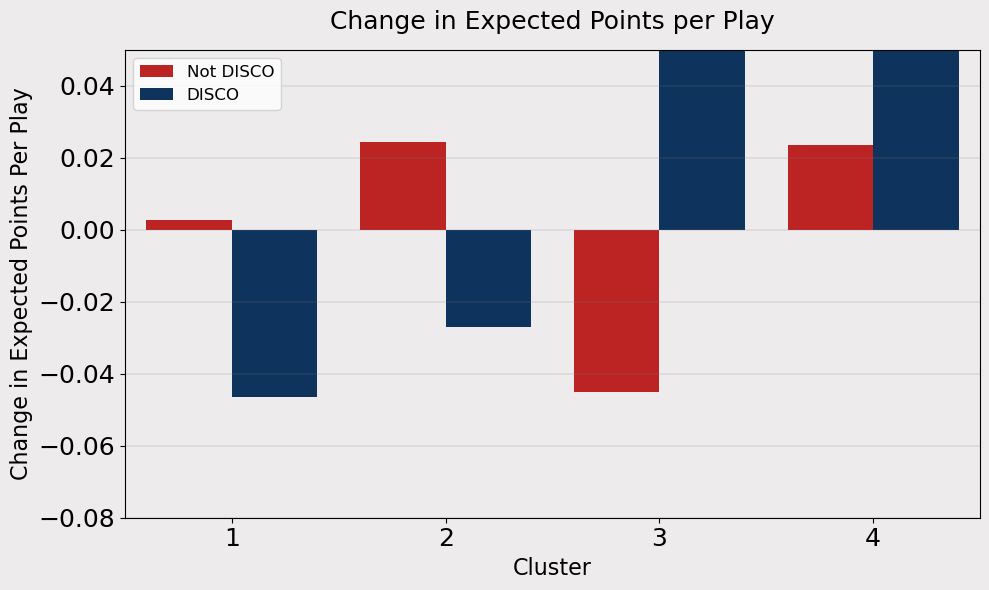

In [751]:
import seaborn as sns
df_performance = pd.merge(df_plays_games, df_features, on = ['gameId', 'playId'], how = 'left')
df_performance = df_performance.groupby(
   ['coverage_cluster_cat', 'disco'
   ] 
).agg(
    {
        'playId': 'count'
        , 'expectedPointsAdded':'mean'
    }
).reset_index()
# Map 'disco' values to labels
df_performance['disco'] = df_performance['disco'].map({0: 'Not DISCO', 1: 'DISCO'})
df_performance['coverage_cluster_cat'] = df_performance['coverage_cluster_cat'].astype(int).astype(str)
df_performance.expectedPointsAdded = df_performance.expectedPointsAdded - df_plays_games.expectedPointsAdded.mean()
# Set colors for the bars
colors = ['#D50A0A', '#013369']  # NFL logo red and blue

# Create the bar plot and assign it to ax
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_performance,
    x='coverage_cluster_cat',
    y='expectedPointsAdded',
    hue='disco',
    palette=colors
)

# Customize the plot
plt.title('Change in Expected Points per Play', fontsize=18, color='black', pad=15)
plt.xlabel('Cluster', fontsize=16, color='black')
plt.ylabel('Change in Expected Points Per Play', fontsize=16, color='black')

# Ensure x-axis shows integers
plt.xticks(fontsize=18, color='black')

# Set y-axis range
plt.ylim(-0.08, 0.05)
plt.yticks(fontsize=18, color='black')

# Adjust legend
plt.legend(title=None, fontsize=12, loc='best')

# Remove gridlines
plt.grid(False)

# Ensure layout fits
plt.tight_layout()
# Enable horizontal gridlines for y-axis ticks
ax.yaxis.grid(True, which='major', linestyle='-', linewidth=0.2, color='grey')
ax.grid(axis='x', visible=False)  # Disable vertical gridlines

# Set background colors to very light grey
ax.set_facecolor('#edebeb')  # Light grey for the plot area
plt.gcf().set_facecolor('#edebeb')  # Light grey for the figure background


# Show the plot
plt.show()

# Conclusion, Limitations, and Future Enhancements

The DISCO metric is not an evaluation of defensive strategy, rather an analysis of defensive strategy.  Being unpredictable sometimes means playing the hand right in front of your opponent’s eyes. Factors such as game situation or player personel could trump the desire to disguise in certain situations.  One intention for use of DISCO would be as a supplement to scouting and film, guiding teams to focus on specific defensive behaviors of their opponents.   Another is for common NFL fans to leverage as they watch games, as it can be fun to predict what teams will do on each play.  

For future enhancements to DISCO: 
- We would want to potentially include the additional variables mentioned above to the model that were not used.
- Factoring in recent play history and game situation, and team history would add more context into team's alignment decisions. 
- We could leverage a supervised machine learning algorithm that incorporates predictive behaviors.
- Using more than 4 clusters may be relevant for some teams and lead to more precise results.
- Looking into blitz disguises (and fake blitzes) would improve DISCO.

# Acknowledgments:

Thank you to the NFL analytics community and the hosts of the Big Data Bowl competition for engaging with fans and data enthusiasts in such a cool way!  Also, thank you to the data engineers and architects who developed Next Gen Stats, providing easily accessible and useable data to the public.  


# Appendix:  
All code is available is github here: